### Import Dataset

In [22]:
if 'google.colab' in str(get_ipython()):
    IN_COLAB = True
else:
    IN_COLAB = False

In [23]:
if IN_COLAB:
  %pip install pycocotools omrdatasettools > /dev/null
  %git clone https://github.com/cakarsubasi/omrtorch.git
  
  print('installed dependencies')


In [24]:

import mung
from pycocotools.coco import COCO
from omrdatasettools import Downloader, OmrDataset
import os

import torch
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.io import read_image
import pandas as pd
from PIL import Image
import json

if IN_COLAB:
    from omrtorch.muscima_utils import *
    from omrtorch.visionutils.engine import train_one_epoch, evaluate
    from omrtorch.visionutils import utils
    from omrtorch.visionutils import transforms as T
    from torchvision.utils import draw_bounding_boxes
else:
    from muscima_utils import *
    from visionutils.engine import train_one_epoch, evaluate
    from visionutils import utils
    from visionutils import transforms as T
    from torchvision.utils import draw_bounding_boxes
# MuscimaMeasures, getMeasureLabels, getListofClassNames

In [25]:
if IN_COLAB:
    downloader = Downloader()
    downloader.download_and_extract_dataset(dataset=OmrDataset.MuscimaPlusPlus_V2, 
                                            destination_directory='muscima')
    downloader.download_and_extract_dataset(dataset=OmrDataset.MuscimaPlusPlus_MeasureAnnotations,
                                            destination_directory="muscima/v2.0/data/measure")
    


In [26]:
imagepath = 'muscima/v2.0/data/images'
annotationpath = 'muscima/v2.0/data/measure/json'

In [27]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

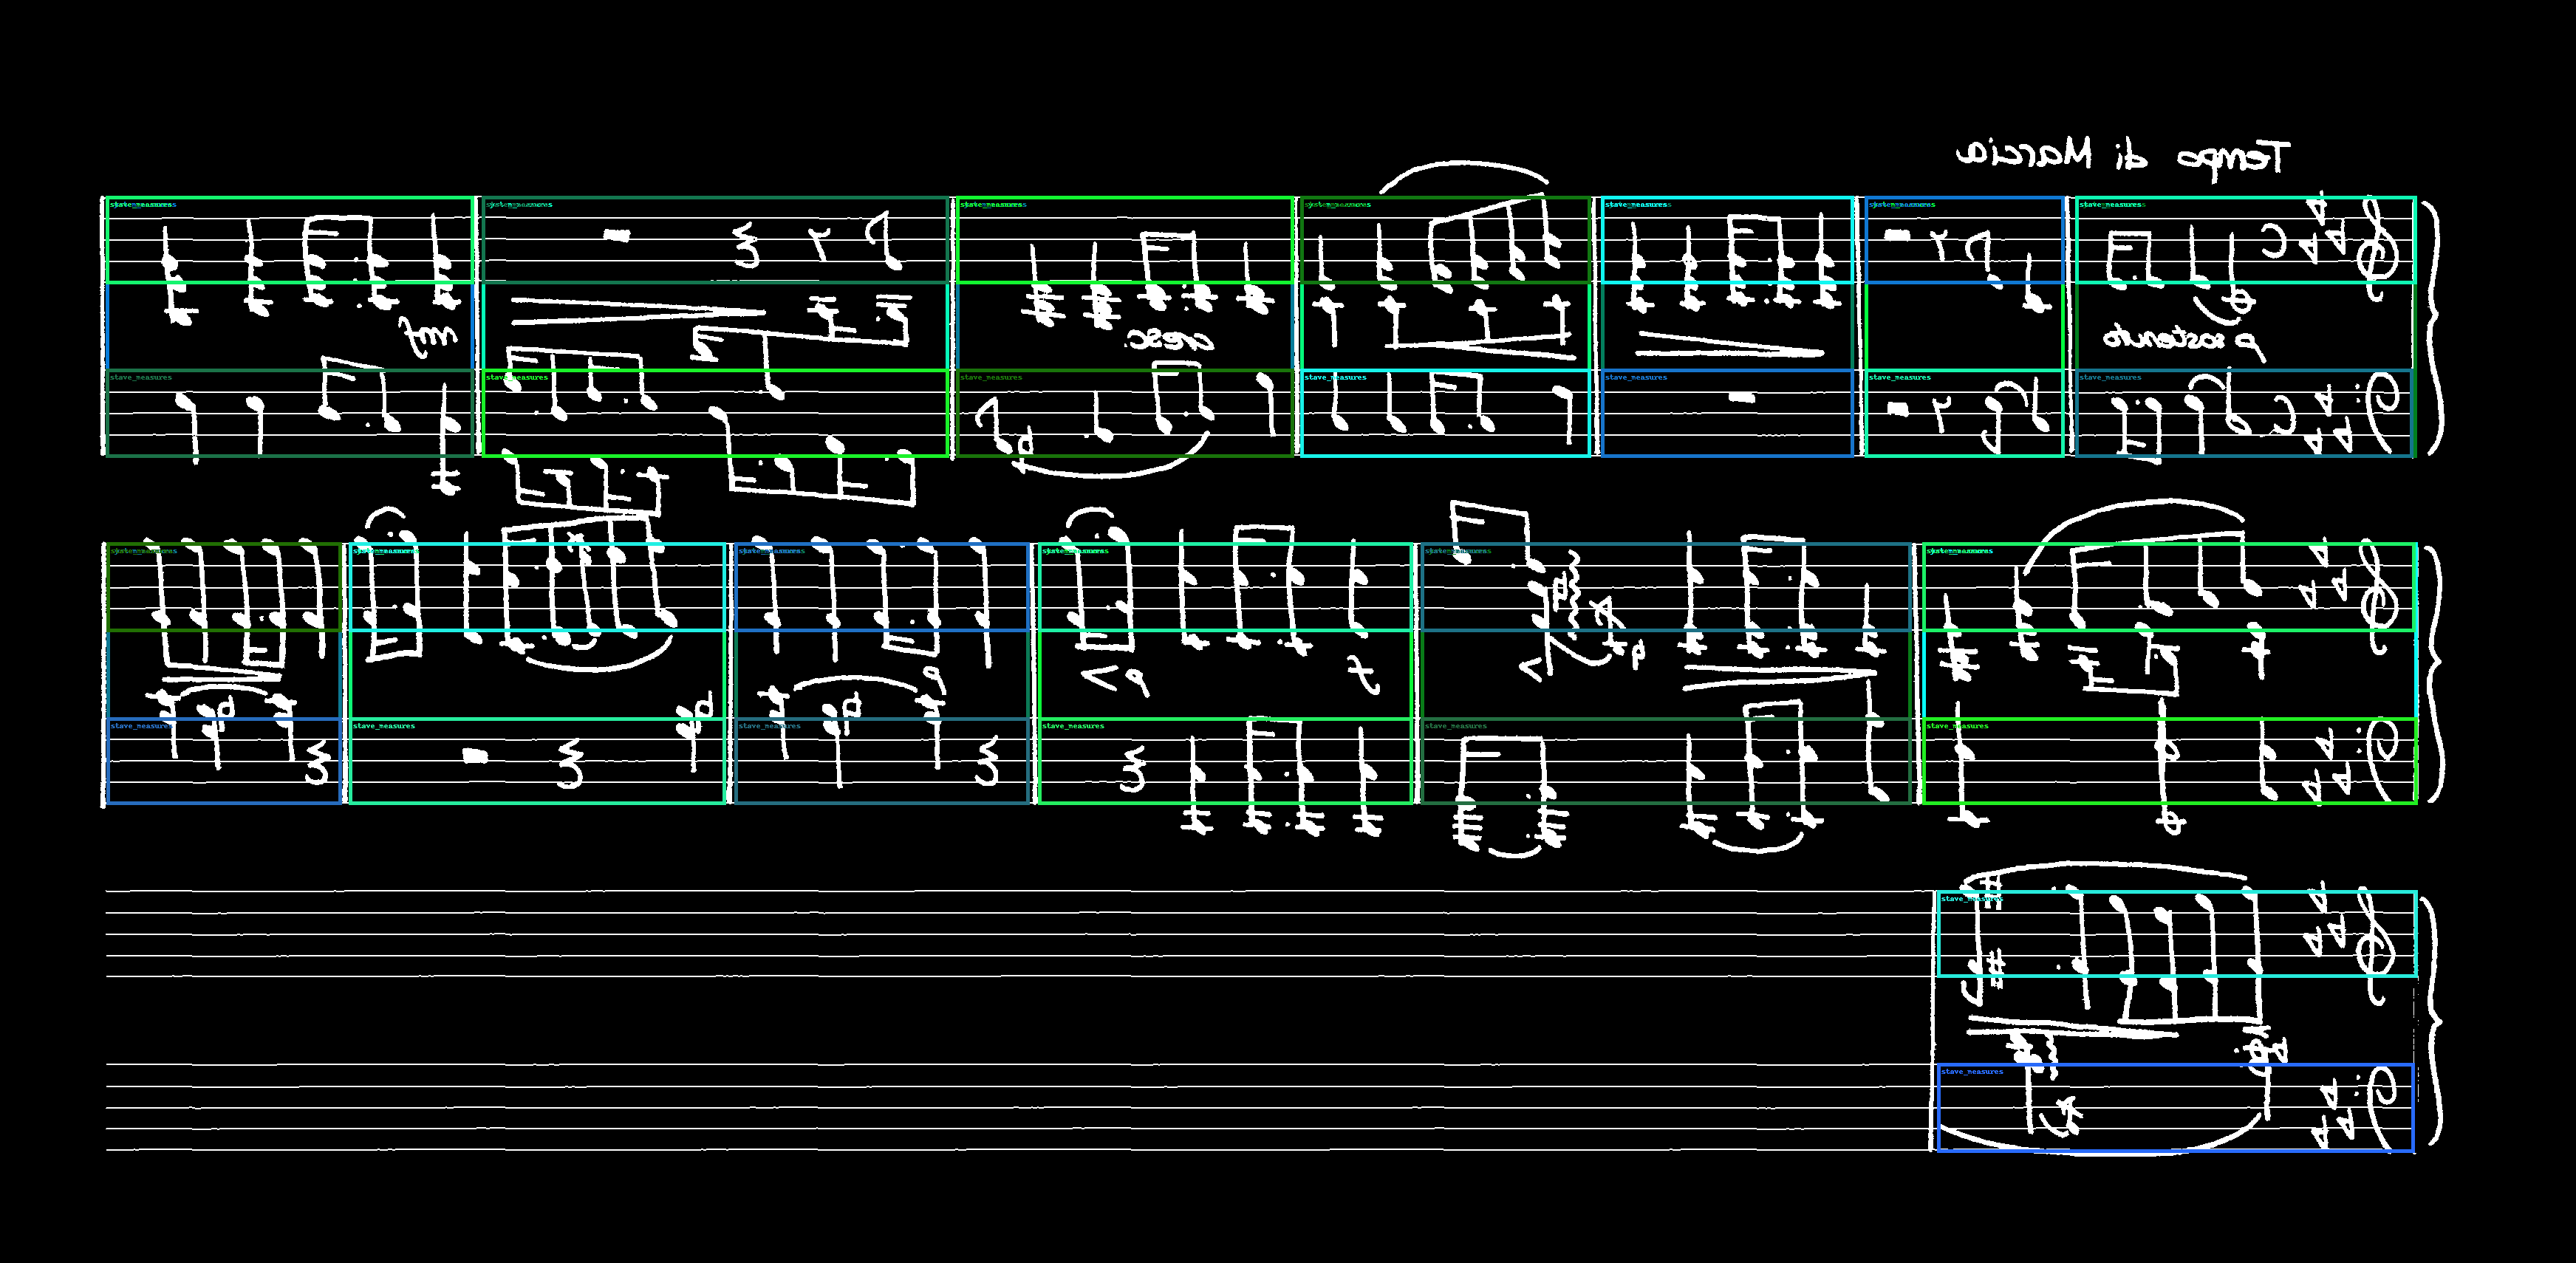

In [28]:
dataset = MuscimaMeasures(imagepath, annotationpath, transforms=get_transform(train=True))
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=utils.collate_fn)

sample_im, sample_ann = dataset[0]
sample_boxes = sample_ann['boxes']
sample_labels = sample_ann['labels']

sample_im = (255*sample_im).type(torch.ByteTensor)
sample_labels2 = getListofClassNames(sample_labels, dataset.label_list)

sample_im_with_bounding_boxes = draw_bounding_boxes(sample_im, sample_boxes, sample_labels2, width=5)

Image.fromarray(np.moveaxis(sample_im_with_bounding_boxes.numpy(), 0, -1))

### Import Model

In [8]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Pretrained model
def get_faster_rcnn_with_n_classes(n: int):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

  in_features = model.roi_heads.box_predictor.cls_score.in_features

  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, n)

  return model

def get_fcos_with_n_classes(n: int):
  model = torchvision.models.detection.fcos_resnet50_fpn(pretrained=False,
       pretrained_backbone=True, num_classes=n)

  return model

def get_gen_rcnn(n: int):
  pass

In [9]:
num_classes = 3

model = get_faster_rcnn_with_n_classes(num_classes)
#model = get_fcos_with_n_classes(num_classes)

In [18]:
backbone = torchvision.models.resnet.resnet50()

In [21]:
model.backbone.out_channels

256

In [15]:
# Test

images, targets = next(iter(dataloader))

images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
#targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)

model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x) 

In [11]:
dataset = MuscimaMeasures(imagepath, annotationpath, transforms=get_transform(train=True))
dataset_test = MuscimaMeasures(imagepath, annotationpath, transforms=get_transform(train=False))

#splits
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-40])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-40:])

print(len(dataset))
print(len(dataset_test))

#dataloaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

100
40


In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)

# optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# learning rate 10x reduction every three epocs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

In [13]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 10

run_training_and_validation = True

if run_training_and_validation:
  for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/50]  eta: 0:02:37  lr: 0.000107  loss: 5.8839 (5.8839)  loss_classifier: 0.8469 (0.8469)  loss_box_reg: 0.3782 (0.3782)  loss_objectness: 4.3630 (4.3630)  loss_rpn_box_reg: 0.2959 (0.2959)  time: 3.1488  data: 0.0430  max mem: 2221
Epoch: [0]  [10/50]  eta: 0:00:38  lr: 0.001126  loss: 2.1341 (2.8867)  loss_classifier: 0.8155 (0.8035)  loss_box_reg: 0.7055 (0.6712)  loss_objectness: 0.2925 (1.0783)  loss_rpn_box_reg: 0.2959 (0.3338)  time: 0.9622  data: 0.0635  max mem: 3317
Epoch: [0]  [20/50]  eta: 0:00:25  lr: 0.002146  loss: 1.8760 (2.3288)  loss_classifier: 0.7309 (0.7237)  loss_box_reg: 0.7055 (0.6830)  loss_objectness: 0.2110 (0.6417)  loss_rpn_box_reg: 0.2366 (0.2804)  time: 0.7207  data: 0.0617  max mem: 3317
Epoch: [0]  [30/50]  eta: 0:00:15  lr: 0.003165  loss: 1.6608 (2.0995)  loss_classifier: 0.5936 (0.6690)  loss_box_reg: 0.6825 (0.6827)  loss_objectness: 0.1234 (0.4829)  loss_rpn_box_reg: 0.1979 (0.2648)  time: 0.7022  data: 0.0608  max mem: 3317
Epoch: [

### Visualize Results

In [14]:
def visualize_bboxes(image, target, labels=None, threshold=0.5):
    colors = ['000000', 'red', 'blue', 'green', 'yellow']
    sample_boxes = target['boxes']
    sample_scores = target['scores']
    sample_labels = target['labels']
    idx = torch.where(sample_scores > threshold)
    boxes_sliced = sample_boxes[idx]
    labels_sliced = sample_labels[idx].tolist()
    colors_list = None
    labels_list_str = None
    if labels is not None:
        labels_list_str = list(labels[val] for val in labels_sliced)
        colors_list = list(colors[val] for val in labels_sliced)
    sample_image = (image*255).type(torch.ByteTensor)

    sample_im_with_bounding_boxes = draw_bounding_boxes(sample_image, boxes_sliced, labels_list_str, colors=colors_list, width=3, font_size=32)

    return Image.fromarray(np.moveaxis(sample_im_with_bounding_boxes.numpy(), 0, -1))


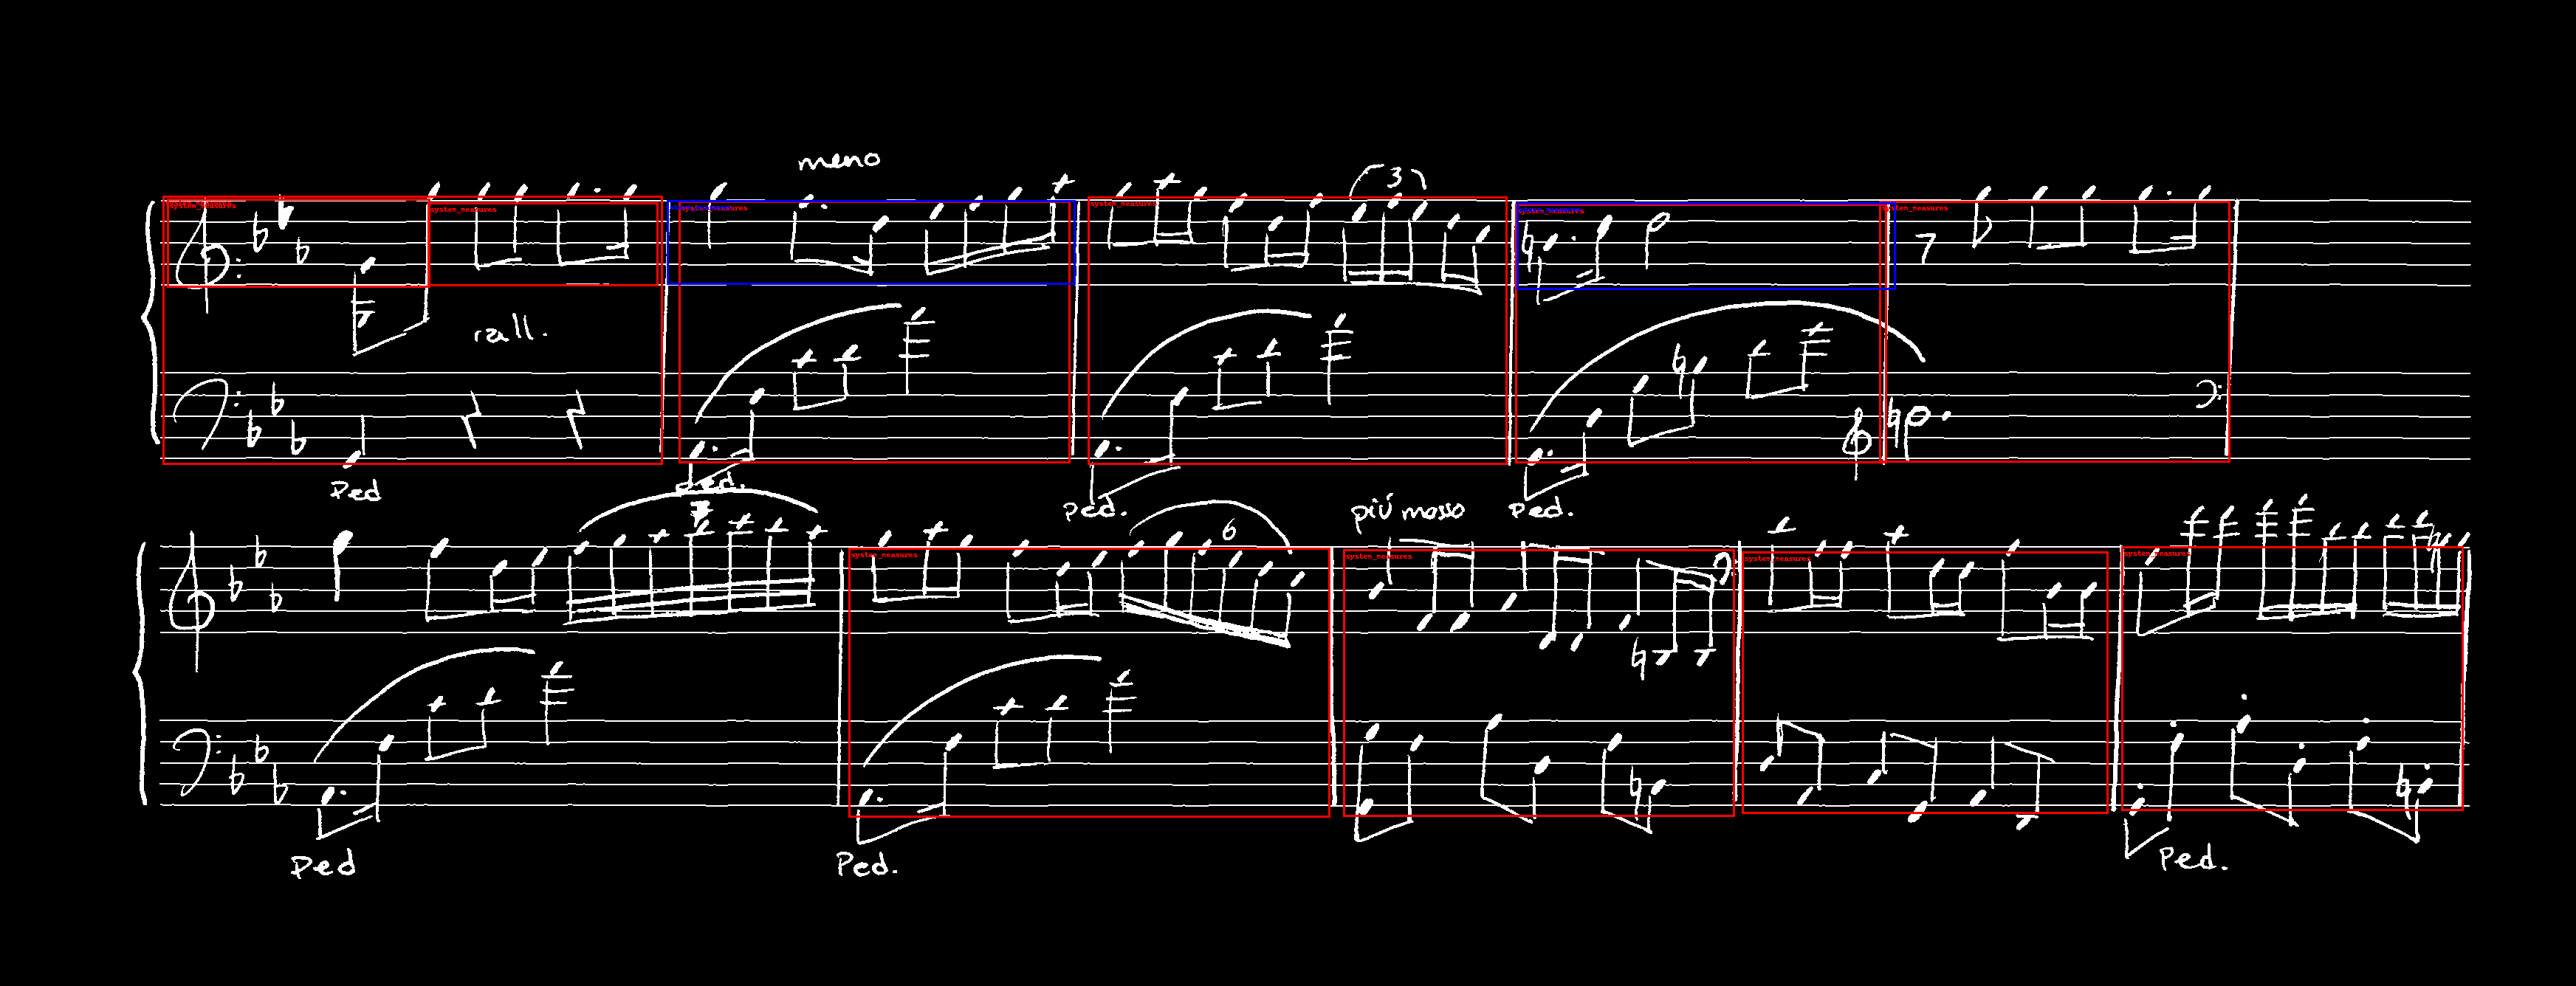

In [30]:
model.eval()
if torch.cuda.is_available():
  torch.cuda.synchronize()
image, target = next(iter(data_loader_test))
image = list(img.to(torch.device('cuda')) for img in image)
detections = model(image)
labels = {1: 'system_measures', 2: 'stave_measures'}
visualize_bboxes(image[0], detections[0], labels, threshold=0.75)

In [29]:
detections[0]['scores']

tensor([0.9288, 0.9263, 0.9257, 0.9207, 0.9161, 0.9135, 0.9096, 0.9080, 0.8708,
        0.8246, 0.7667, 0.7616, 0.7604, 0.7273, 0.7219, 0.7204, 0.7138, 0.6591,
        0.6562, 0.6477, 0.6457, 0.6409, 0.6299, 0.6293, 0.6160, 0.6121, 0.6115,
        0.6110, 0.6095, 0.6031, 0.6030, 0.6006, 0.5933, 0.5868, 0.5677, 0.5656,
        0.5644, 0.5238, 0.5115, 0.5106, 0.5023, 0.4854, 0.4814, 0.4611, 0.4589,
        0.4506, 0.4493, 0.4355, 0.4350, 0.4208, 0.4021, 0.3834, 0.3692, 0.3668,
        0.3359, 0.3257, 0.3149, 0.2816, 0.2649, 0.2533, 0.2434, 0.2300, 0.2251,
        0.2174, 0.2150, 0.1665, 0.1459, 0.1371, 0.1309, 0.1304, 0.1176, 0.1161,
        0.1082, 0.0973, 0.0888, 0.0808, 0.0807, 0.0741, 0.0719, 0.0712, 0.0548,
        0.0528], device='cuda:0', grad_fn=<IndexBackward0>)

### Save Model

In [ ]:
# Model state_dict
#print("Model's state dict:")
#for param_tensor in model.state_dict():
#  print(param_tensor, "\t", model.state_dict()[param_tensor].size())
#
#print()
#
## Optimizer state_dict
#print("Optimizer's state_dict:")
#for var_name in optimizer.state_dict():
#  print(var_name, "\t", optimizer.state_dict()[var_name])

In [ ]:
# Example only save parameters
# SAVE_PARAMETERS = "state_dict_model.pt"
# 
# torch.save(model.state_dict(), SAVE_PARAMETERS)
# 
# model2 = get_faster_rcnn_with_n_classes(2)
# model2.load_state_dict(torch.load(SAVE_PARAMETERS))
# 
# model2.eval()

In [21]:
# Example save everything
SAVE_ENTIRE_MODEL = "measures.pt"

torch.save(model, SAVE_ENTIRE_MODEL)

model3 = torch.load(SAVE_ENTIRE_MODEL)
model3.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(